# Miniproject 2 - Part 1

Reminders:

In this case, the rows (0th dimension) represents the number of data points in time. The columns (or 1st dimension) represents the number of channels in each data point.

most EMG signals concentrate in frequencies lower than 500Hz. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

/Users/romy/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1) Loading, visualizing & Preprocessing

Steps:
- load
- denoising (bandpass to isolate freq of interest) --> butterworth filter with cutoff frequencies at 5Hz and 500Hz

acquired signal might contain noticeable powergrid noise. The powergrid operates at 50Hz in Europe (60Hz in the US and Japan). if it is significant, it is necessary to filter it out using a bandstop filter. Depending on the strength of the powergrid noise, you might need to filter the harmonics of it (the integer multiples of 50Hz +- 2Hz). 

# !!!!! A VÉRIFIER: PAS SÛR QU'IL FALLAIT EN FAIT DENOISE ETC LES SIGNAUX PSQ ASKIP SELON LES PAPERS ILS SONT DÉJÀ DENOISE??? JE SUIS PAS SÛRE D'AVOIR COMPRIS !!!!!

In [2]:
# Sampling frequency (Hz)
fs = 100 # found in paper (see below)

# load EMG data
EMG_file_name='./s2/S2_A1_E1.mat'
data = loadmat(EMG_file_name)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])


In Acquisition setup:

"Data from the CyberGlove were transmitted over a Bluetooth-tunneled serial port at slightly less than 25 Hz; data from the inclinometer, the FFLS and the Otto-Bock sEMG electrodes were acquired at **100 Hz** using a National Instruments data acquisition card (NI-DAQ PCMCIA 6024E, 12-bit resolution); the Delsys base station received the sEMG and accelerometer streams via an ad-hoc wireless network and relayed the data via a standard USB connection"

Source : https://www.nature.com/articles/sdata201453

For each subject and exercise, the database contains one file in Matlab format (www.mathworks.com) with synchronized variables. The variables included in the files are:

- subject (n° of subject)
- exercise (n° of exercise done)
- stimulus (1 column): the original label of the movement repeated by the subject;
- emg --> sEMG signal of the electrodes; columns 1–8 include the signal from the electrodes equally spaced around the forearm; columns 9 and 10 include the signal from the electrodes located on the main activity spots of the muscle Flexor Digitorum Superficialis and of the muscle Extensor Digitorum Superficialis14; when available, columns 11 and 12 include the signal from the main activity spots of the muscle Biceps Brachii and of the muscle Triceps Brachii; (Shape: (number_timepoints, number_channels) = emg.shape)
- glove (22 columns): uncalibrated signal from the 22 sensors of the Cyberglove. The raw data are declared to be proportional to the angles of the joints in the CyberGlove manual; details on the location of the sensors are available at the link: ninapro.hevs.ch/node/123;
- restimulus (1 column): the a-posteriori refined label of the movement;
- repetition (1 column): stimulus repetition index;
- rerepetition (1 column): restimulus repetition index;

Source : https://www.nature.com/articles/sdata201453

In [3]:
emg = data['emg']
data_shape = emg.shape
number_timepoints = emg.shape[0]
number_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {number_timepoints} timepoints')
print(f'There are {number_channels} channels')

The shape of the data is (100686, 10)
There are 100686 timepoints
There are 10 channels


In [4]:
# Extract labels
labels = data['restimulus'].flatten()

# Extract repetition indices
repetition = data['rerepetition'].flatten()

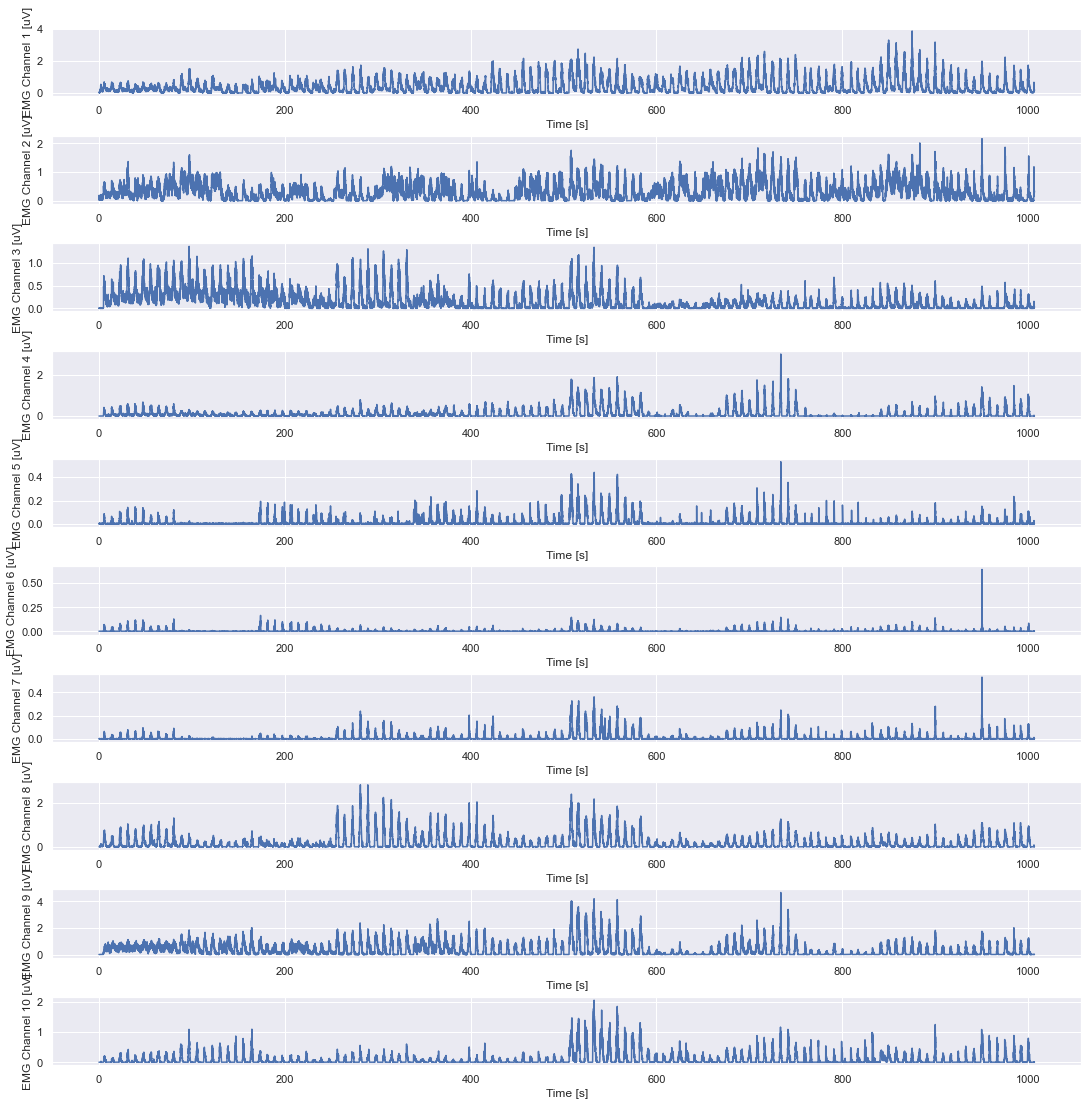

In [5]:
# Visualization of raw EMG signals

time_steps = np.arange(0, number_timepoints/fs, 1/fs)

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"EMG Channel {channel_idx + 1} [uV]")

plt.show()

In [6]:
# PREPROCESSING:

# Apply bandpass filter between 5 Hz and 45 Hz --> depends on sampling freq

bandpass_cutoff_frequencies_Hz = (10, 45)
sos = butter(N=4, Wn=np.array(bandpass_cutoff_frequencies_Hz) / (fs / 2), btype="bandpass", output="sos")
emg_filtered = sosfiltfilt(sos, emg, axis=0)

According to the Nyquist theorem, the maximum frequency that can be accurately represented without aliasing is half the sampling frequency : 

fe = fsamp/2 = 100/2 = 50 Hz

- **Upper cutoff freq:** must be below fe (avoid aliasing)
- **Lower cutoff freq:** must be approx. above 10 Hz (avoid artifacts) BUT some muscle activation signals can contain useful informaiton starting around 5 Hz --> **5 or 10 Hz????**

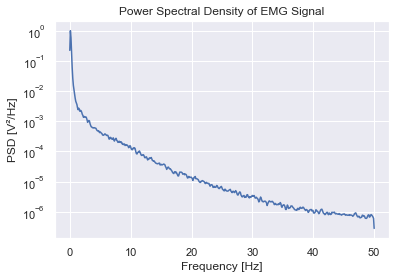

In [7]:
# plot freq spectrum of EMG signals using power spectral density estimates (Welch) --> see where signal energy = concentrated
# to decide if lower cutoff freq = 5 or 10 Hz
freqs, psd = welch(emg[:, 0], fs=fs, nperseg=1024)
plt.semilogy(freqs, psd)
plt.title('Power Spectral Density of EMG Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.show()

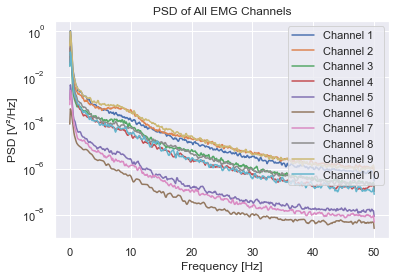

In [8]:
# Examine the PSD of multiple channels to see if it's a common pattern or issues w/spe electrodes

for i in range(number_channels):
    freqs, psd = welch(emg[:, i], fs=fs, nperseg=1024)
    plt.semilogy(freqs, psd, label=f'Channel {i+1}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.title('PSD of All EMG Channels')
plt.legend()
plt.show()

it seems like all channels show the same pattern, with channels 2 and 9 showing an additional bump at approx. f = 8-9 Hz. this could correspond to artifacts. therefore I think setting the lower cutoff at **10 Hz** might be a better idea since it seems like for all the channels the remaining frequencies still carry enough info when f > 10 Hz.

In [26]:
# powergrid noise???????

# not possible to filter 50 Hz noise (= powerline noise in Europe)
# bc it sits at Nyquist frequency & freq at or beyond it are not properly
# represented (aliasing) ==> NOT A PROBLEM FOR THIS DATASET!!!

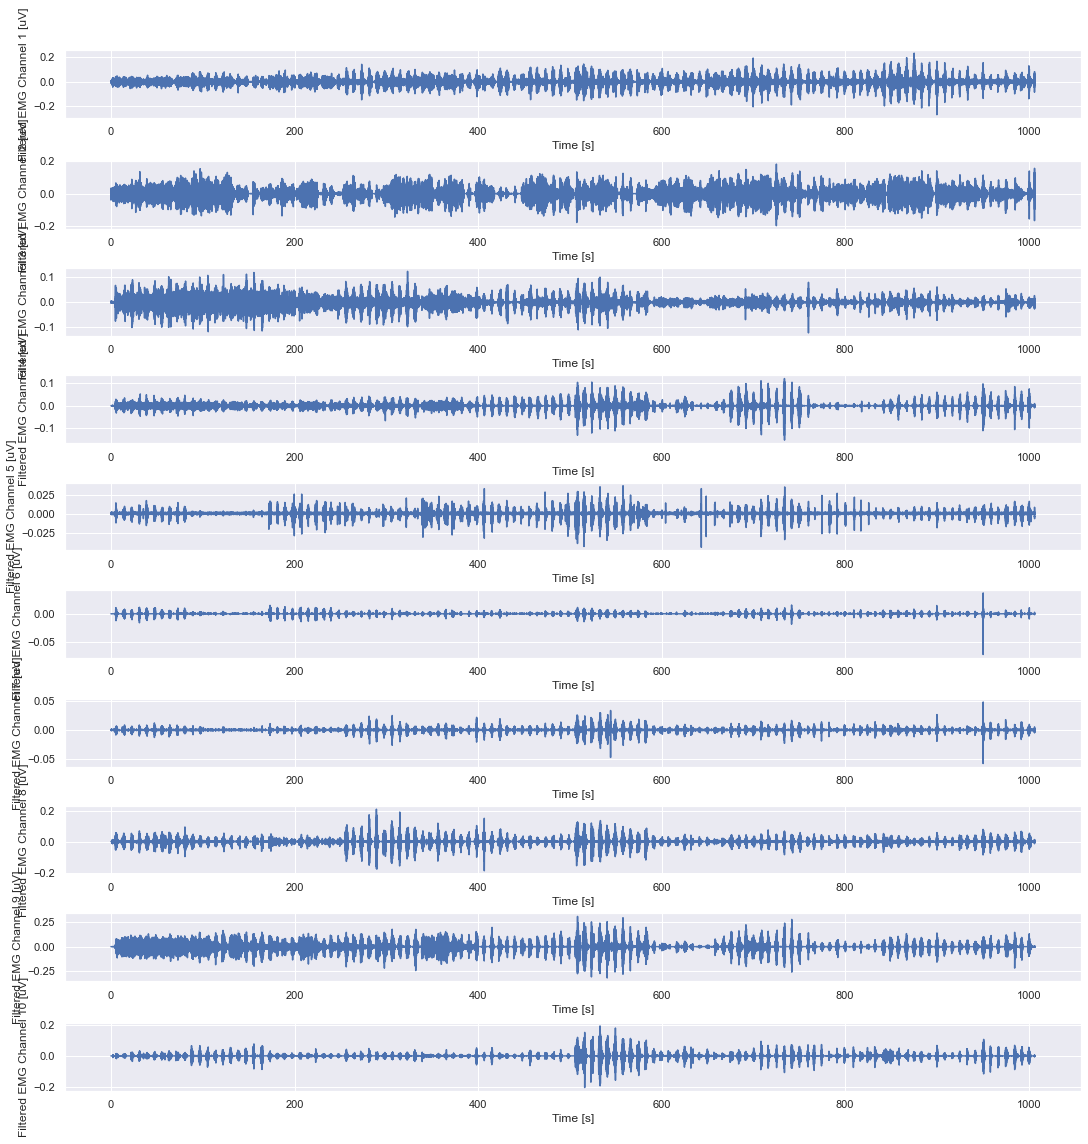

In [9]:
# Visualization of filtered EMG signals

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg_filtered[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"Filtered EMG Channel {channel_idx + 1} [uV]")

plt.show()

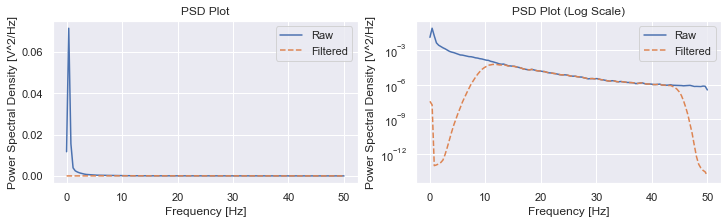

In [10]:
# Use Welch's method for power spectral density estimation (it changed after filtering), it reduces the variance of the estimate.

freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=256)
freqs_post, Pxx_post = welch(emg_filtered[:, 0], fs=fs, nperseg=256)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="Raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="Filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density [V^2/Hz]")
ax[0].set_title("PSD Plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="Raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="Filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density [V^2/Hz]")
ax[1].set_title("PSD Plot (Log Scale)")
plt.show()

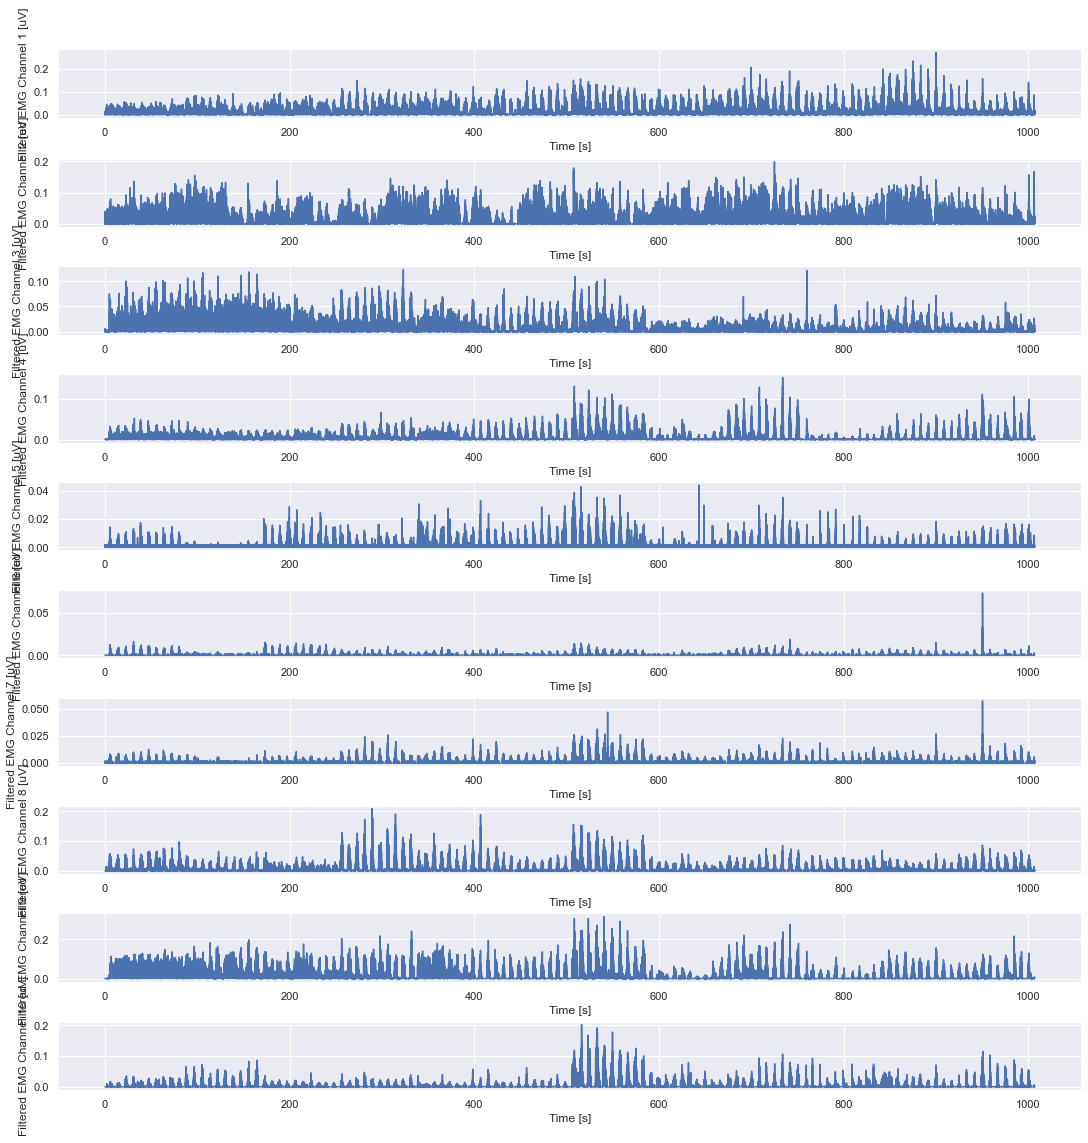

In [11]:
# Rectify the signal in order to better quantify the muscular activation.

emg_rectified = np.abs(emg_filtered)

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"Filtered EMG Channel {channel_idx + 1} [uV]")

plt.show()

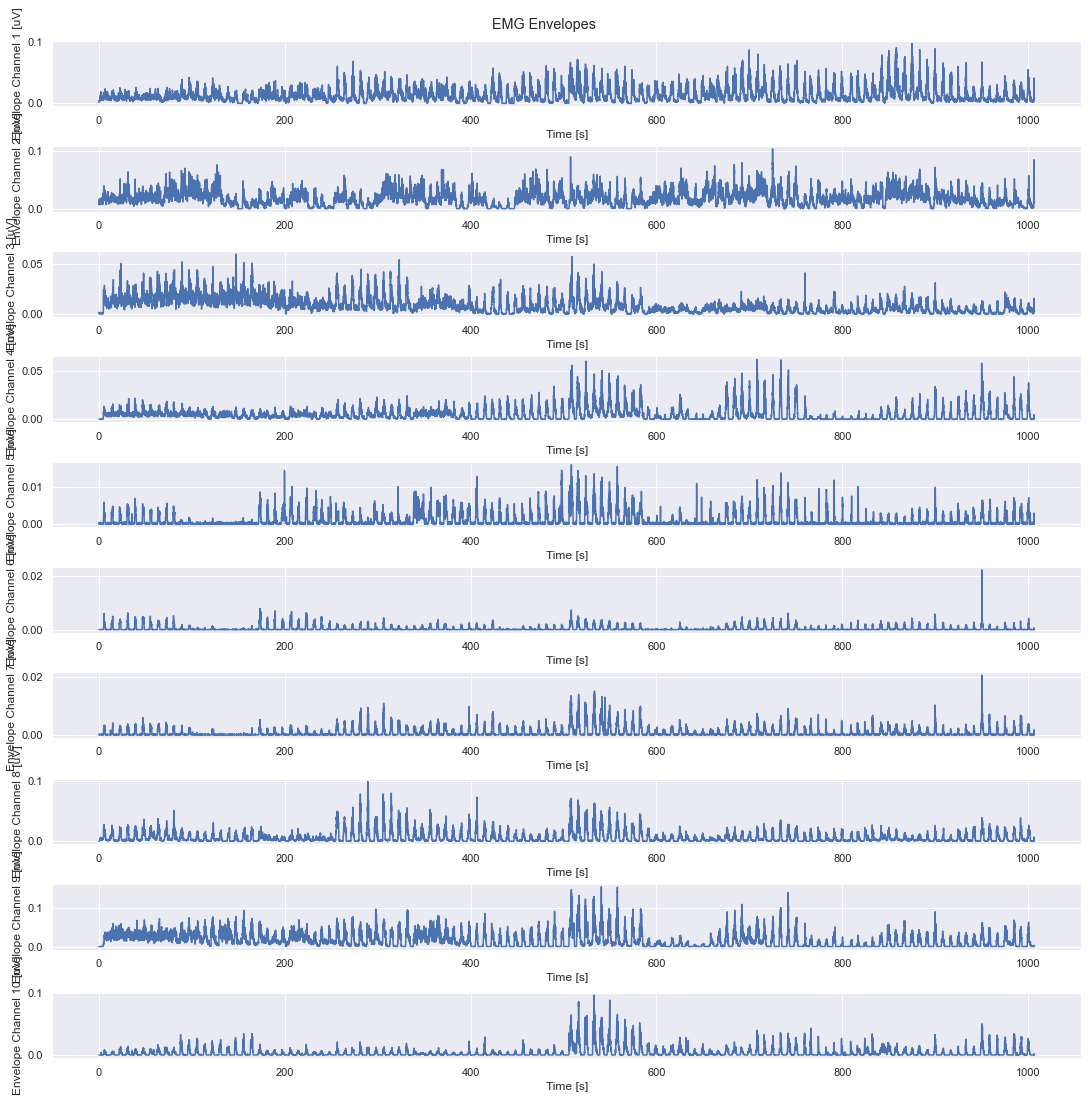

In [12]:
# compute the envelop of the signal by applying a moving average

mov_mean_size = int(fs * 0.2)  # For a 200 ms window --> CHECK IF IT'S APPROPRIATE!!!!
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots(number_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(number_channels):
    ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"Envelope Channel {channel_idx + 1} [uV]")
plt.suptitle("EMG Envelopes")
plt.show()

## 2) Identifying bad trials

# entre ici et en bas (jusqu'aux autres pointillés) pas sûr que ce soit ce qu'il faille faire, c'était plus des tests
# ----------------------------------------------------------------------------

In [23]:
# Segment data into trials to associate data w/spe mov (= corresponding labels)

unique_labels = np.unique(labels)
print(f"Unique movement classes: {unique_labels}")

# Find indices where the movement label changes
label_changes = np.diff(labels, prepend=labels[0])

# Find the start and end indices of each movement class
trial_indices = []
current_label = labels[0]
start_idx = 0
for idx, change in enumerate(label_changes):
    if change != 0:
        end_idx = idx
        trial_indices.append((current_label, start_idx, end_idx))
        current_label = labels[idx]
        start_idx = idx
# Append the last trial
trial_indices.append((current_label, start_idx, len(labels)))

# Remove trials with label 0 (rest period)
trial_indices = [t for t in trial_indices if t[0] != 0]

print(f"Number of trials: {len(trial_indices)}")

Unique movement classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Number of trials: 120


When inspecting trials, look for:

- Sudden jumps or drops in signal amplitude
- Flat lines (which may indicate sensor dropout)
- Excessive noise

--> using descriptive stats:

In [31]:
from scipy.stats import skew, kurtosis

# EXTRACT EMG DATA FOR EACH TRIAL

# Initialize a list to store statistics for each trial
trial_stats = []

for trial_num, (label, start_idx, end_idx) in enumerate(trial_indices):
    # Extract the trial data
    trial_data = emg_envelopes[start_idx:end_idx, :]  # Shape: (time_points, channels)
    
    # Compute statistics for each channel
    mean_vals = np.mean(trial_data, axis=0)
    std_vals = np.std(trial_data, axis=0)
    skew_vals = skew(trial_data, axis=0)
    kurt_vals = kurtosis(trial_data, axis=0)
    
    # Store the statistics in a dictionary
    stats = {
        'trial_num': trial_num,
        'label': label,
        'mean': mean_vals,
        'std': std_vals,
        'skew': skew_vals,
        'kurtosis': kurt_vals
    }
    trial_stats.append(stats)

In [32]:
# Collect all statistics into arrays for analysis
means = np.array([stat['mean'] for stat in trial_stats])      # Shape: (num_trials, num_channels)
stds = np.array([stat['std'] for stat in trial_stats])
skews = np.array([stat['skew'] for stat in trial_stats])
kurts = np.array([stat['kurtosis'] for stat in trial_stats])

In [33]:
# Compute mean and std across all trials for each channel
mean_of_means = np.mean(means, axis=0)
std_of_means = np.std(means, axis=0)

mean_of_stds = np.mean(stds, axis=0)
std_of_stds = np.std(stds, axis=0)

# Compute z-scores
mean_zscores = (means - mean_of_means) / std_of_means
std_zscores = (stds - mean_of_stds) / std_of_stds

In [34]:
# Set a z-score threshold
zscore_threshold = 3

# Identify outliers in mean and std
mean_outliers = np.abs(mean_zscores) > zscore_threshold
std_outliers = np.abs(std_zscores) > zscore_threshold

# Identify trials with any outlier channels
outlier_trials = []
for i in range(mean_outliers.shape[0]):
    if np.any(mean_outliers[i, :]) or np.any(std_outliers[i, :]):
        outlier_trials.append(trial_stats[i]['trial_num'])

In [35]:
print(f"Trials with potential outliers based on z-score threshold {zscore_threshold}:")
print(outlier_trials)

Trials with potential outliers based on z-score threshold 3:
[5, 33, 34, 36, 59, 60, 61, 62, 63, 64, 65, 66, 84, 86, 87, 88, 102, 104, 113]


### Signal-to-Noise ratio
(to assess quality of EMG signal by comparing the power of the signal to the power of the noise)

In [36]:
# Extract rest period indices
rest_indices = np.where(labels == 0)[0]

# Ensure rest periods are contiguous
rest_label_changes = np.diff(rest_indices)
split_points = np.where(rest_label_changes > 1)[0] + 1
rest_segments = np.split(rest_indices, split_points)

# Collect rest data
rest_data = np.concatenate([emg_envelopes[segment, :] for segment in rest_segments if len(segment) > 0], axis=0)

# Compute noise variance for each channel
noise_variance = np.var(rest_data, axis=0)

# Compute signal variance & SNR for each trial
for stat in trial_stats:
    trial_num = stat['trial_num']
    label, start_idx, end_idx = trial_indices[trial_num]
    trial_data = emg_envelopes[start_idx:end_idx, :]
    
    # Compute signal variance for each channel
    signal_variance = np.var(trial_data, axis=0)
    
    # Compute SNR in decibels (dB)
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    snr = 10 * np.log10((signal_variance + epsilon) / (noise_variance + epsilon))
    
    # Store SNR in the stats dictionary
    stat['snr'] = snr

In [37]:
# Collect SNR values
snr_values = np.array([stat['snr'] for stat in trial_stats])

# Define SNR threshold
snr_threshold = 5  # in dB

# Identify trials where any channel has SNR below the threshold
low_snr_trials = []
for i in range(snr_values.shape[0]):
    if np.any(snr_values[i, :] < snr_threshold):
        low_snr_trials.append(trial_stats[i]['trial_num'])

print(f"Trials with SNR below {snr_threshold} dB:")
print(low_snr_trials)

Trials with SNR below 5 dB:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


# -------------------------------------------------------------------------------------

### Determine nb of stimuli, repetitions, channels

In [13]:
# Exclude the rest class (label 0)
n_stimuli = len(np.unique(labels)) - 1  # Subtract 1 for rest class
n_repetitions = len(np.unique(repetition)) - 1  # Subtract 1 if repetitions start from 0
n_channels = emg_rectified.shape[1]

print(f'Number of stimuli (movements): {n_stimuli}')
print(f'Number of repetitions: {n_repetitions}')
print(f'Number of channels: {n_channels}')

print(f'Unique repetitions: {np.unique(repetition)}') # repetitions start from 0

Number of stimuli (movements): 12
Number of repetitions: 10
Number of channels: 10
Unique repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]


In [17]:
# nb of samples per trial

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(1, n_stimuli + 1):  # Adjust index range if needed
    for repetition_idx in range(1, n_repetitions + 1):
        idx = np.logical_and(labels == stimuli_idx, repetition == repetition_idx)
        number_of_samples_per_trial[stimuli_idx - 1, repetition_idx - 1] = np.sum(idx)

print(number_of_samples_per_trial) # for the 120 trials

[[307. 390. 262. 226. 418. 204. 196. 270. 306. 489.]
 [334. 323. 344. 309. 333. 376. 362. 307. 348. 339.]
 [465. 352. 450. 460. 436. 389. 323. 388. 383. 316.]
 [310. 402. 357. 396. 255. 333. 263. 369. 438. 471.]
 [516. 382. 425. 379. 463. 411. 387. 343. 286. 377.]
 [337. 319. 337. 368. 338. 336. 268. 354. 319. 313.]
 [428. 392. 341. 393. 421. 445. 342. 328. 329. 358.]
 [289. 372. 406. 397. 498. 336. 415. 328. 472. 405.]
 [384. 424. 371. 316. 280. 314. 342. 284. 307. 421.]
 [311. 296. 299. 296. 301. 246. 213. 317. 493. 221.]
 [352. 403. 338. 416. 330. 355. 313. 322. 329. 219.]
 [270. 330. 300. 387. 295. 204. 363. 267. 281. 329.]]


In [18]:
# Define the window length in samples
window_length_ms = 200 # NOT SURE THE WINDOW IS OKAY????????
mov_mean_length = int(fs * window_length_ms / 1000)
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# initialize data structures
emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

# segment data into trials & compute envelopes
for stimuli_idx in range(1, n_stimuli + 1):
    for repetition_idx in range(1, n_repetitions + 1):
        idx = np.logical_and(labels == stimuli_idx, repetition == repetition_idx)
        idx = idx.flatten()
        emg_window = emg_rectified[idx, :]
        emg_windows[stimuli_idx - 1][repetition_idx - 1] = emg_window
        
        # Compute the moving average (EMG envelope)
        emg_envelope = convolve1d(emg_window, mov_mean_weights, axis=0, mode='constant')
        emg_envelopes[stimuli_idx - 1][repetition_idx - 1] = emg_envelope

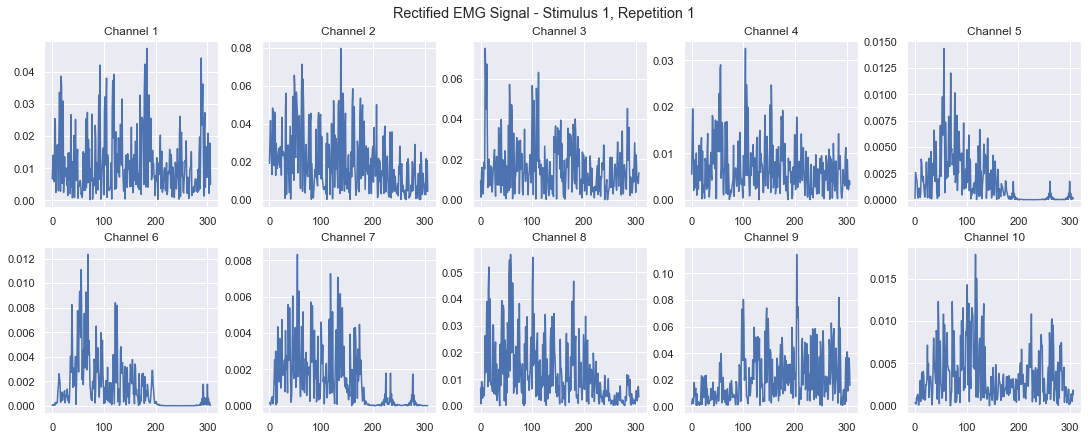

In [19]:
# plot rectified EMG signal for 1st stimulus & repetition

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("Rectified EMG Signal - Stimulus 1, Repetition 1")

plt.show()

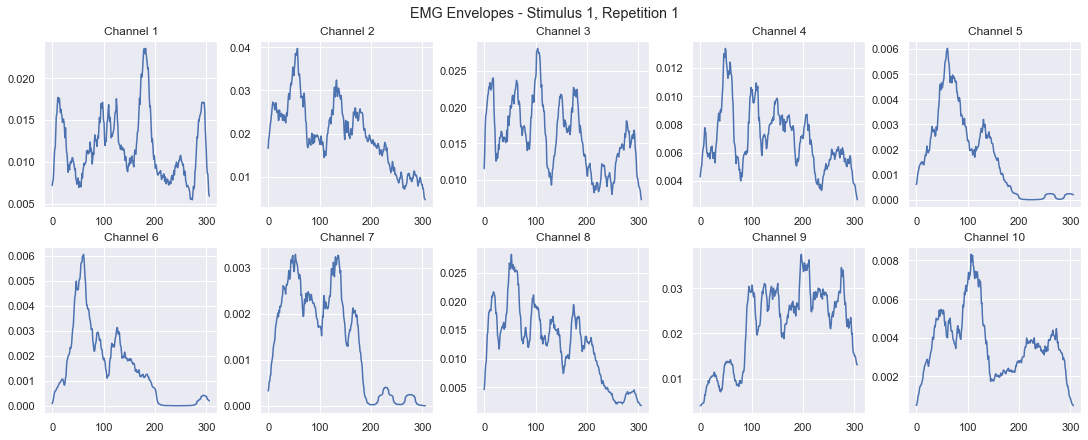

In [20]:
# plot EMG envelopes

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("EMG Envelopes - Stimulus 1, Repetition 1")
plt.show()

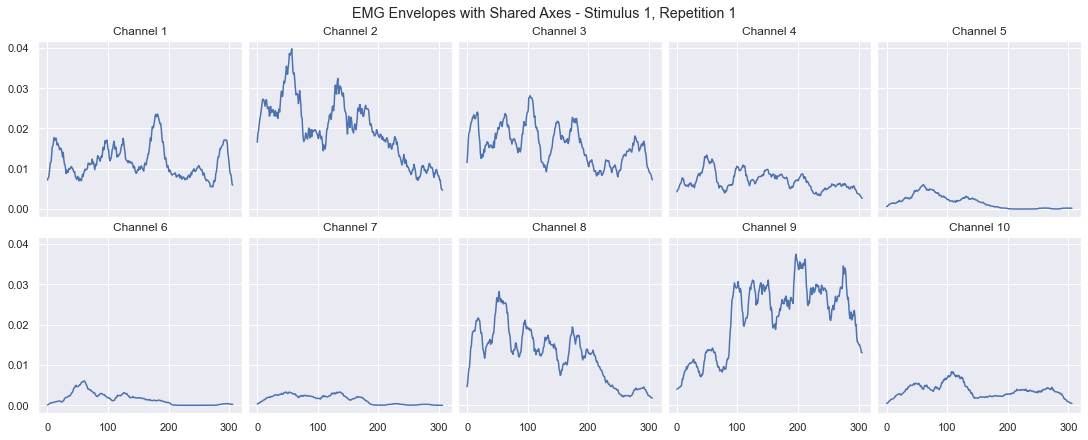

In [21]:
# shared axes to compare across channels

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("EMG Envelopes with Shared Axes - Stimulus 1, Repetition 1")
plt.show()

exclude a channel??? trials???? comment les sélectionner et les exclure par rapport à ce qu'on voit?

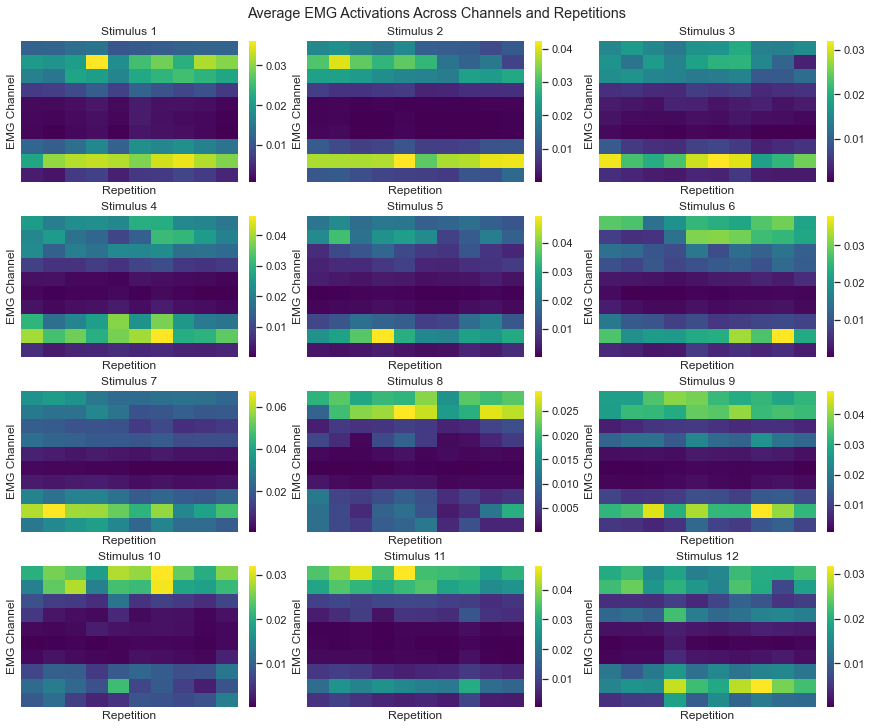

In [22]:
# compute average activations

emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        emg_envelope = emg_envelopes[stimuli_idx][repetition_idx]
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelope, axis=0)

fig, ax = plt.subplots(4, 3, figsize=(12, 10), constrained_layout=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(
        emg_average_activations[:, stimuli_idx, :],
        ax=ax[stimuli_idx],
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        cmap='viridis'
    )
    ax[stimuli_idx].set_title(f"Stimulus {stimuli_idx + 1}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")
plt.suptitle("Average EMG Activations Across Channels and Repetitions")
plt.show()

The rows represent the activity recorded by each channel in response to repeated stimuli.
The columns correspond to each repetition of the stimulus. Variability across columns is expected due to several factors.

it appears that different stimuli elicit activation in different muscle groups. However, a more thorough analysis is required to confirm this observation. One approach could be to normalize the signals, making them more comparable across channels. This normalization would help in identifying specific patterns of muscle activation unique to each stimulus, providing deeper insights into the neuromuscular responses elicited by different stimuli.

### comment analyser ces trucs????

## 3) Feature creation & selection

In [1]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [ ]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0) 
# # Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0) 
# # Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0)) 
# # Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0) 
# # Slope sign changes (SSC)
def ssc(x, threshold=0):
    diff_signal = np.diff(x, axis=0)
    ssc_values = np.sum(((diff_signal[:-1] * diff_signal[1:]) < -threshold).astype(int), axis=0)
    return ssc_values
#Feel free to add more features, e.g. frequency domain features from the two papers 
# zero crossing rate?
# autoregressive coeff?
# READ PAPERS!!!!!!!!!!!!!!!


# SPLITTING DATA BEFORE??? but we're not selecting features here, just candidates?? --> À VÉRIFIER!!!!
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=labels,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc] # Uncomment this line to use all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")


## 4) Splitting data and testing w/GRADIENT BOOSTING!!

In [ ]:
# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3)

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train a classifier on the normalized data -> GRADIENT BOOSTING
clf = GradientBoostingClassifier(ramdom_state=40)
clf.fit(X_train_z, y_train)  # Fit the model on the training data

# Evaluate the classifier on the test set
# Predict the labels for the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

## 5) Hyperparameter tuning (CROSS-VALIDATION)

In [ ]:
# Perform cross-validation

# 'clf' is your classifier, 'X_train_z' is the normalized training data, 'y_train' are the training labels
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

In [ ]:
# Use cross-validation to find the best hyperparameters for GRADIENT BOOSTING

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV with the classifier and parameter grid
grid = GridSearchCV(GradientBoostingClassifier(random_state=40), param_grid, cv=5)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Predict the labels for the test set using the best estimator
y_pred = grid.predict(X_test_z)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}") 

## 6) Feature selection

In [ ]:
# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 10 features based on mutual information scores.
k_best = SelectKBest(mutual_info_classif, k=10)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

# Initialize the classifier with the best parameters found earlier --> CHANGE TO GRADIENT BOOSTING!!!
clf = GradientBoostingClassifier(**grid.best_params_)  # Use the best parameters found before
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_best)

# Calculate the accuracy of the model with the selected features.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()